In [1]:
!pip install spektral
!pip install --upgrade git+https://github.com/danielegrattarola/spektral.git

  Cloning https://github.com/danielegrattarola/spektral.git to /private/var/folders/7q/fws4rlfs7rv4sxqpn_xpmr6m0000gn/T/pip-req-build-kbxk1d8_
  Running command git clone --filter=blob:none --quiet https://github.com/danielegrattarola/spektral.git /private/var/folders/7q/fws4rlfs7rv4sxqpn_xpmr6m0000gn/T/pip-req-build-kbxk1d8_
  Resolved https://github.com/danielegrattarola/spektral.git to commit a5fa5e38fca4eaca1e47ccfe1b00e0a61f64648b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# spektral
from spektral.datasets import TUDataset
from spektral.data import Dataset
from spektral.layers import GCNConv, GlobalAvgPool, GlobalMaxPool, GlobalSumPool
from spektral.data import DisjointLoader

# reg
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.sparse import SparseTensor


from itertools import product

# Q1: Exploring and Visualizing the PROTEINS Dataset [2 pts]

1. Dataset Inspection & Statistics

○ a. Load the PROTEINS dataset using the provided code from the lecture.

○ b. Print the total number of graphs, the number of node features per graph, and the number of classes.

In [3]:
# load proteins dataset
dataset = TUDataset("PROTEINS")

# print total n of graphs, n of node featrues per graph, and n of classes
print("Total graphs in PROTEINS:", len(dataset))
print("Number of node features per graph:", dataset.n_node_features)
print("Number of classes:", dataset.n_labels)

Successfully loaded PROTEINS.
Total graphs in PROTEINS: 1113
Number of node features per graph: 4
Number of classes: 2


2. Computing Graph Statistics

○ a. Iterate over all graphs in the dataset to compute:

    ■ The number of nodes per graph.

    ■ The number of edges per graph (remember that for undirected graphs each edge is counted twice).

    ■ The global label for each graph (convert from a one-hot vector to an integer).

○ b. Store these statistics as NumPy arrays.

3. Visualization

In [4]:
# initialize empty to store iterations
num_nodes = []
num_edges = []
labels = []

# iterate over  1113 graphs
for graph in dataset:
    # number of nodes per graph
    num_nodes.append(graph.n_nodes)

    # number of edges per graph/avoid double counting edges
    num_edges.append(graph.n_edges // 2)
    
    # global label for each graph (convert from a one-hot vector to an integer)
    labels.append(np.argmax(graph.y))

# store statistics as np arrays
num_nodes = np.array(num_nodes)
num_edges = np.array(num_edges)
labels = np.array(labels)

○ a. Plot a histogram of the number of nodes per graph.

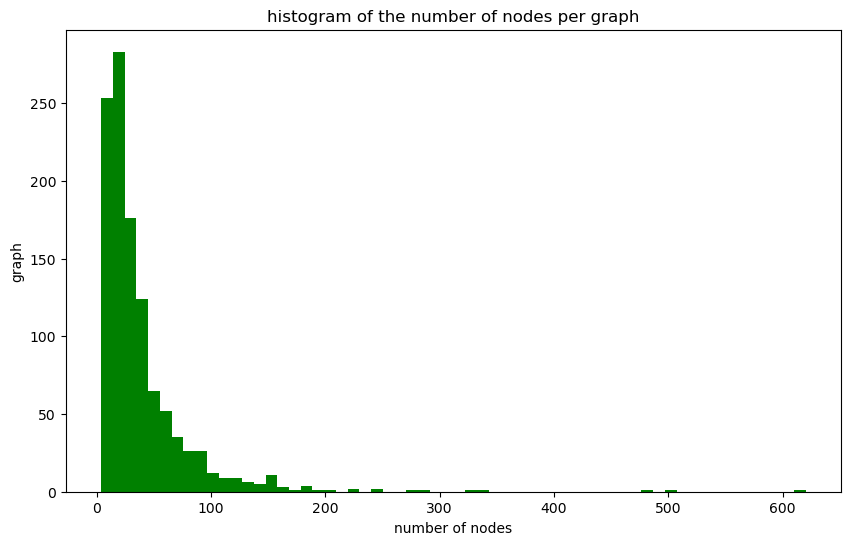

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(num_nodes, bins=60, color='green')
plt.title('histogram of the number of nodes per graph')
plt.xlabel('number of nodes')
plt.ylabel('graph')
plt.show()

○ b. Plot a histogram of the number of edges per graph.

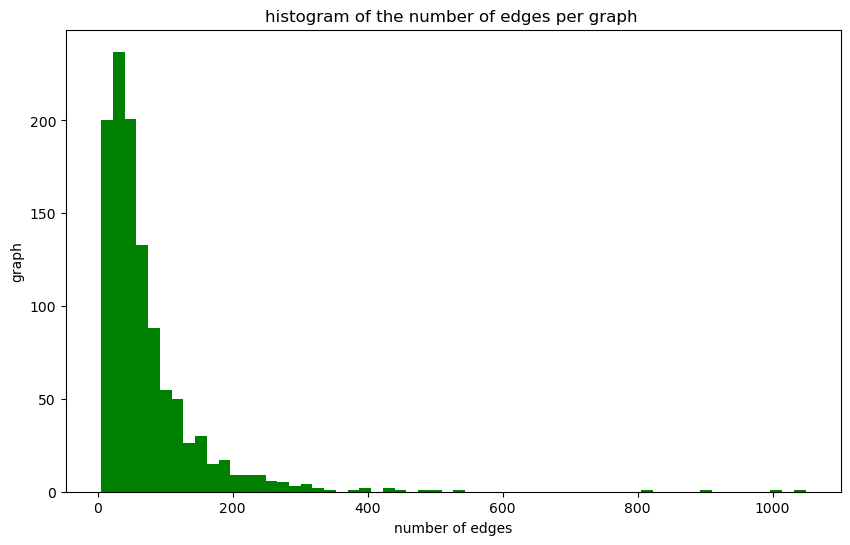

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(num_edges, bins=60, color='green')
plt.title('histogram of the number of edges per graph ')
plt.xlabel('number of edges')
plt.ylabel('graph')
plt.show()

○ c. Create a bar plot to show the distribution of graph labels.

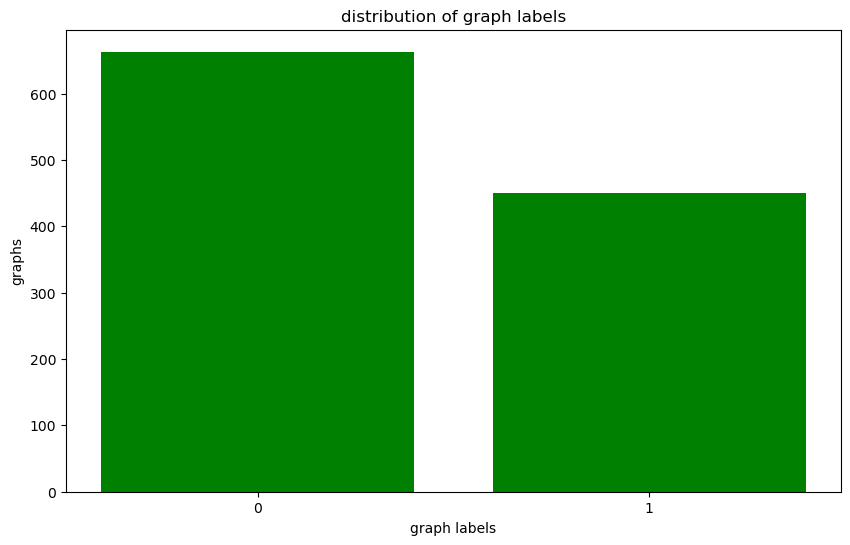

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(np.unique(labels), np.bincount(labels), color='green')
plt.title('distribution of graph labels')
plt.xticks(np.arange(0,2,1))
plt.xlabel('graph labels')
plt.ylabel('graphs')
plt.show()

Discuss:

● How do the distributions of nodes and edges inform you about the complexity of the dataset?

● What observations can you make about the distribution of graph labels and how might these affect model training?

The distributions of nodes and edges are both right skewed, with most graphs having between 0-100 nodes and 0-200 edges. This tells us this is a very complex dataset. 

Regarding graph labels, there is a class imbalance with more graphs having a label of 0 than 1. This imbalance could cause bias towards the majority class (0) and lead to poor performance and capturing of patterns/complexities in the minority class (1). 

# Q2: Building and Evaluating a Graph Convolutional Network (GCN) [2 pts]

1. Dataset Preparation

○ Split the dataset into training and testing sets (80-20% split) by implementing a custom SubsetDataset wrapper using the provided code from the lecture.

In [8]:
# Split indices for training and test sets
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Define a custom Dataset wrapper to hold a list of graphs
class SubsetDataset(Dataset):
    def __init__(self, graphs, **kwargs):
        self._graphs = graphs
        super().__init__(**kwargs)

    def read(self):
        return self._graphs

# Create training and test datasets using the wrapper
train_graphs = [dataset[i] for i in train_idx]
test_graphs = [dataset[i] for i in test_idx]

train_dataset = SubsetDataset(train_graphs)
test_dataset = SubsetDataset(test_graphs)

print("Training graphs:", len(train_dataset))
print("Test graphs:", len(test_dataset))

Training graphs: 890
Test graphs: 223


2. Model Construction

○ a. Build a GCN model using TensorFlow and Spektral:

    ■ Define the inputs for disjoint mode (node features, adjacency matrix, and graph indices).

    ■ Create two GCN layers (you may use a custom GCN layer if desired) followed by a global pooling layer (e.g., GlobalAvgPool).

    ■ Add a Dense output layer with softmax activation for classification.

○ b. Compile the model using the Adam optimizer and categorical crossentropy
loss.

In [9]:
# Define inputs for disjoint mode:
# node features; features of nodes in each graph
x_in = Input(shape=(dataset.n_node_features,), name='node_features')

# adj matrix; connections between nodes
a_in = Input(shape=(None,), sparse=True, name='adjacency_matrix')

# graph indices for handling multiple graphs in a batch
i_in = Input(shape=(), name='graph_index', dtype="int32")

In [10]:
class MyGCNConv(GCNConv):
    def compute_mask(self, inputs, mask=None):
        # Ignore mask propagation: always return None
        return None

    def call(self, inputs, **kwargs):
        # Remove mask and training kwargs if present:
        kwargs.pop('mask', None)
        kwargs.pop('training', None)
        return super().call(inputs, **kwargs)

    def compute_output_shape(self, input_shape):
        # input_shape is a tuple: (x_shape, a_shape)
        # x_shape: (num_nodes, n_features) → output: (num_nodes, channels)
        return (input_shape[0][0], self.channels)

In [11]:
# Use your custom convolution layers instead of the standard GCNConv:
x = MyGCNConv(32, activation='relu')([x_in, a_in])
x = MyGCNConv(32, activation='relu')([x, a_in])

# aggregate node features into single representation per graph 
pool = GlobalAvgPool()([x, i_in])

# output layer for clas
output = Dense(dataset.n_labels, activation='softmax')(pool)

In [12]:
# compile model
model = Model(inputs=[x_in, a_in, i_in], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_features       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_matrix    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_gcn_conv         │ (None, 32)        │        160 │ node_features[0]… │
│ (MyGCNConv)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_gcn_conv_1       │ (None, 32)        │      1,056 │ my_gcn_conv[0][0… │
│ (MyGCNConv)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_index         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 32)        │          0 │ my_gcn_conv_1[0]… │
│ (GlobalAvgPool)     │                   │            │ graph_index[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │         66 │ global_avg_pool[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

3. Training & Evaluation

○ a. Train the model for 20 epochs using DisjointLoaders for both the training and test sets.

○ b. Plot the training and test loss as well as the accuracy curves over the epochs.

○ c. Evaluate the model on the test set and report the final test loss and accuracy.

In [13]:
# Now you can create DisjointLoaders without the 'signature' error:
from spektral.data.loaders import DisjointLoader

train_loader = DisjointLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DisjointLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=20,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch
)

Epoch 1/20


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['node_features', 'adjacency_matrix', 'graph_index']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


16/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3871 - loss: 8.6479    

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SubsetDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4264 - loss: 6.5935 - val_accuracy: 0.5785 - val_loss: 0.8206
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6536 - loss: 0.8079 - val_accuracy: 0.6323 - val_loss: 0.8055
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6829 - loss: 0.6487 - val_accuracy: 0.6009 - val_loss: 0.7558
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 0.6527 - val_accuracy: 0.6502 - val_loss: 0.7368
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6635 - loss: 0.6792 - val_accuracy: 0.6233 - val_loss: 0.7221
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6723 - loss: 0.6543 - val_accuracy: 0.5785 - val_loss: 0.7646
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6905 - loss: 0.6201 - val_accuracy: 0.6323 - val_loss: 0.7280
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 0.6203 - val_accuracy: 0.6323 - val_loss: 0.7043
Epo

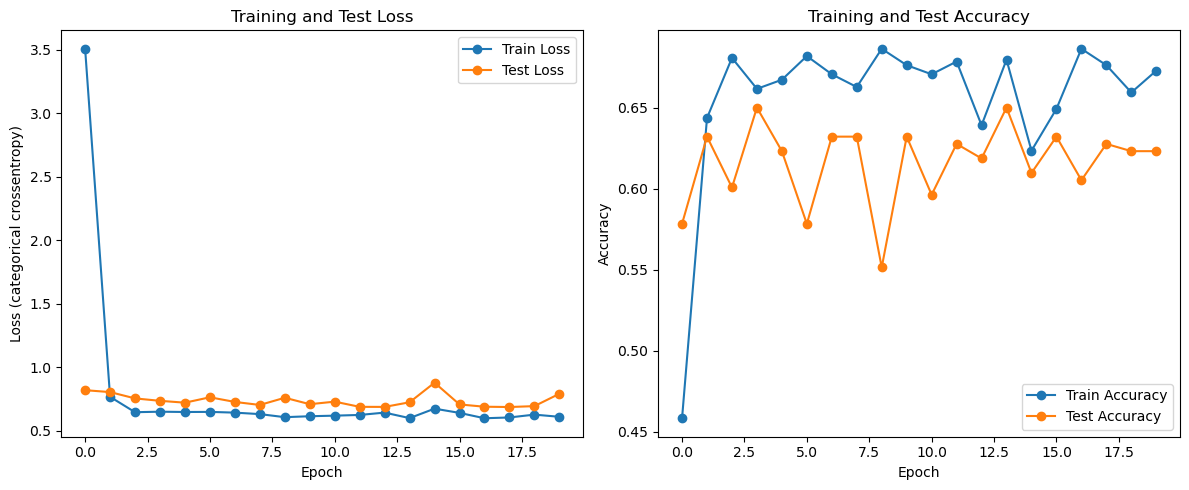

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (categorical crossentropy)')
plt.title('Training and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
test_loss, test_accuracy = model.evaluate(
    test_loader.load(),
    steps=test_loader.steps_per_epoch
)

print(f"final testing loss: {test_loss}")
print(f"final testing accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6302 - loss: 0.7694 
final testing loss: 0.792084813117981
final testing accuracy: 0.6233183741569519


The model did face challenges involving overfitting as well as low accuracies. A technique could be learning rate schedules to help the optimizer converge more effectively or even early stopping. Regularization can be used to help reduce overfitting. 

# Q3: Hyperparameter Tuning for GCN Models on a Sampled PROTEINS Subset [3 pts]

1. Dataset Subsampling & Preparation

○ Split this subset into training and test sets (80-20% split) and set up DisjointLoaders for each.

○ Randomly sample 300 graphs for hyperparameter search.

In [17]:
sampled_train_graphs = np.random.choice(train_graphs, 300, replace=False)

2. Model Building with Hyperparameters

○ Define a function to build a GCN model that accepts hyperparameters for:

    ■ The number of GCN layers.
    ■ Dropout rate (optional dropout after each layer).
    ■ The choice of pooling layer (e.g., GlobalAvgPool, GlobalSumPool, GlobalMaxPool).
    ■ Learning rate.
    
○ Compile the model with the appropriate loss and optimizer settings

In [18]:
# parameters: 
'''The number of GCN layers.
■ Dropout rate (optional dropout after each layer).
■ The choice of pooling layer (e.g., GlobalAvgPool, GlobalSumPool,
GlobalMaxPool).
■ Learning rate.
'''

# returns compiled GCN model
def build_gcn_model(num_layers, dropout_rate, pooling_type, learning_rate, input_shape, num_classes):
    # input layer
    x_in = Input(shape=(input_shape,), name='node_features')
    # adjacency matrix; connections between nodes
    a_in = Input(shape=(None,), sparse=True, name='adjacency_matrix')
    # graph indices for handling multiple graphs in a batch
    i_in = Input(shape=(), name='graph_index', dtype="int32")
    

    # GCN layers
    x = x_in
    for _ in range(num_layers):
        x = MyGCNConv(32, activation='relu')([x, a_in]) 
         # Dropout after each GCN layer
        x = Dropout(dropout_rate)(x)

    # pooling
    if pooling_type == 'avg':
        x = GlobalAvgPool()([x, i_in])  
    elif pooling_type == 'sum':
        x = GlobalSumPool()([x, i_in]) 
    elif pooling_type == 'max':
        x = GlobalMaxPool()([x, i_in])  
    
#     # fully connected layers
#     x = Dense(64, activation='relu')(x) 
#     x = Dropout(dropout_rate)(x) 
    output = Dense(num_classes, activation='softmax')(x)

    # model
    model = Model(inputs=[x_in, a_in, i_in], outputs=output)

    # complie
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
num_layers = 3
dropout_rate = 0.5
pooling_type = 'avg' 
learning_rate = 0.001
input_shape = 4
num_classes = 2

# Build and compile the model
model = build_gcn_model(num_layers, dropout_rate, pooling_type, learning_rate, input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_features       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_matrix    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_gcn_conv_2       │ (None, 32)        │        160 │ node_features[0]… │
│ (MyGCNConv)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ my_gcn_conv_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_gcn_conv_3       │ (None, 32)        │      1,056 │ dropout[0][0],    │
│ (MyGCNConv)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ my_gcn_conv_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_gcn_conv_4       │ (None, 32)        │      1,056 │ dropout_1[0][0],  │
│ (MyGCNConv)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ my_gcn_conv_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_index         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool_1   │ (None, 32)        │          0 │ dropout_2[0][0],  │
│ (GlobalAvgPool)     │                   │            │ graph_index[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         66 │ global_avg_pool_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,338 (9.13 KB)

 Trainable params: 2,338 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_hp = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=20,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch
)


hp_test_loss, hp_test_accuracy = model.evaluate(
    test_loader.load(),
    steps=test_loader.steps_per_epoch
)

print(f"test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4555 - loss: 32.2834 - val_accuracy: 0.5919 - val_loss: 13.2130
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5138 - loss: 7.8316 - val_accuracy: 0.5874 - val_loss: 6.9762
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5542 - loss: 5.7518 - val_accuracy: 0.5874 - val_loss: 4.3575
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5430 - loss: 4.4568 - val_accuracy: 0.5874 - val_loss: 4.4325
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5924 - loss: 3.0941 - val_accuracy: 0.5874 - val_loss: 3.1134
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5410 - loss: 3.2969 - val_accuracy: 0.5919 - val_loss: 2.6502
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5185 - loss: 3.2382 - val_accuracy: 0.5919 - val_loss: 1.6262
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5415 - loss: 2.0231 - val_accuracy: 0.5919 - val_los

3. Grid Search & Visualization

○ Define a grid of hyperparameter combinations:

    ■ Number of layers: [1, 2, 3]
    
    ■ Dropout rates: [0.1, 0.2, 0.3]
    
    ■ Learning rates: [0.001, 0.0005, 0.0001]
    
    ■ Pooling variants: GlobalAvgPool, GlobalSumPool, GlobalMaxPool
    
○ Visualize the distribution of test accuracies for each hyperparameter using box
plots.

In [21]:
# define hyperparam grid
num_layers = [1, 2, 3]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.0005, 0.0001]
pooling_var = ['avg','sum','max']

param_grid = list(product(num_layers, dropout_rates, learning_rates, pooling_var))

In [22]:
# train model using hyperparams 
results = []

for num_layers, dropout_rates, learning_rates, pooling_var in param_grid:
    print(f"Training model with: layers = {num_layers}, dropout = {dropout_rates}, lr = {learning_rates}, pooling = {pooling_var}")
    
    model=build_gcn_model(num_layers, dropout_rates, pooling_var, learning_rates, input_shape, num_classes)
    
    history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=20,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch
    )


    test_loss, test_accuracy = model.evaluate(
    test_loader.load(),
    steps=test_loader.steps_per_epoch,
    verbose=1
    )
    
    results.append({
        'num_layers': num_layers,
        'dropout_rate': dropout_rates,
        'learning_rate': learning_rates,
        'pooling variants': pooling_var,
        'test_accuracy': test_accuracy
    })


Training model with: layers = 1, dropout = 0.1, lr = 0.001, pooling = avg
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5555 - loss: 1.5324 - val_accuracy: 0.6143 - val_loss: 0.7149
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6099 - loss: 0.7736 - val_accuracy: 0.6368 - val_loss: 0.7159
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5758 - loss: 0.8225 - val_accuracy: 0.6143 - val_loss: 0.6955
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5884 - loss: 0.7419 - val_accuracy: 0.6054 - val_loss: 0.7054
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5399 - loss: 0.7756 - val_accuracy: 0.6054 - val_loss: 0.6829
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5640 - loss: 0.7631 - val_accuracy: 0.6188 - val_loss: 0.6791
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5393 - loss: 0.7837 - val_accuracy: 0.5874 - val_loss: 0.6945
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5699 - loss: 0.8084 - val_accuracy: 0.5830 - val_loss: 0.8896
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6204 - loss: 0.7565 - val_accuracy: 0.6054 - val_loss: 0.7331
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6148 - loss: 0.7147 - val_accuracy: 0.6054 - val_loss: 0.7061
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6222 - loss: 0.7087 - val_accuracy: 0.5830 - val_loss: 0.7080
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6094 - loss: 0.6868 - val_accuracy: 0.6009 - val_loss: 0.7161
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6092 - loss: 0.7486 - val_accuracy: 0.6054 - val_loss: 0.7128
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6219 - loss: 0.7184 - val_accuracy: 0.5919 - val_loss: 0.7045
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6105 - loss: 0.7070 - val_accuracy: 0.6143 - val_loss: 0.6

Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5682 - loss: 6.9248 - val_accuracy: 0.6413 - val_loss: 2.6582
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 7.8185 - val_accuracy: 0.6054 - val_loss: 4.1443
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6386 - loss: 5.0375 - val_accuracy: 0.6502 - val_loss: 3.2143
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6621 - loss: 2.8751 
Training model with: layers = 1, dropout = 0.1, lr = 0.0005, pooling = max
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5811 - loss: 2.0583 - val_accuracy: 0.5830 - val_loss: 1.7493
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5618 - loss: 0.8846 - val_accuracy: 0.5830 - val_loss: 1.4852
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6048 - loss: 0.7447 - val_accuracy: 0.5740 - val_loss: 1.3481
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6185 - loss: 0.8170 - val_accu

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5540 - loss: 5.4379 - val_accuracy: 0.6099 - val_loss: 5.5503
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5681 - loss: 5.9973 - val_accuracy: 0.6233 - val_loss: 2.7439
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5353 - loss: 5.7944 - val_accuracy: 0.6188 - val_loss: 3.2097
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5747 - loss: 4.9952 - val_accuracy: 0.6188 - val_loss: 2.8224
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5793 - loss: 4.8530 - val_accuracy: 0.6009 - val_loss: 4.6810
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5894 - loss: 5.5209 - val_accuracy: 0.6054 - val_loss: 1.9115
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5825 - loss: 4.5872 - val_accuracy: 0.6009 - val_loss: 2.9261
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5927 - loss: 4.9676 - val_accuracy: 0.5964 - val_loss: 4.2100


Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5199 - loss: 1.0324 - val_accuracy: 0.5964 - val_loss: 0.7073
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5463 - loss: 0.8810 - val_accuracy: 0.6054 - val_loss: 0.6819
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.7968 - val_accuracy: 0.6099 - val_loss: 0.6724
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5689 - loss: 0.8403 - val_accuracy: 0.6188 - val_loss: 0.6758
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6124 - loss: 0.7592 - val_accuracy: 0.6099 - val_loss: 0.6772
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6229 - loss: 0.7876 - val_accuracy: 0.6592 - val_loss: 0.6711
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5412 - loss: 0.8581 - val_accuracy: 0.6502 - val_loss: 0.6735
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6446 - loss: 0.6822 
Training model with: layers = 1, dropou

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6011 - loss: 2.6904 - val_accuracy: 0.4126 - val_loss: 0.9296
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4600 - loss: 1.0300 - val_accuracy: 0.5964 - val_loss: 0.7419
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5884 - loss: 0.8007 - val_accuracy: 0.6054 - val_loss: 0.7424
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6038 - loss: 0.8713 - val_accuracy: 0.6054 - val_loss: 0.7163
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - loss: 0.8794 - val_accuracy: 0.5964 - val_loss: 0.7080
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6033 - loss: 0.8230 - val_accuracy: 0.5919 - val_loss: 0.7091
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5424 - loss: 0.8997 - val_accuracy: 0.6233 - val_loss: 0.6906
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5571 - loss: 0.8687 - val_accuracy: 0.5695 - val_loss: 0.6918
Epo

Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6399 - loss: 0.7294 - val_accuracy: 0.6906 - val_loss: 0.6392
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6619 - loss: 0.7378 - val_accuracy: 0.5381 - val_loss: 0.7251
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5945 - loss: 0.7547 - val_accuracy: 0.6502 - val_loss: 0.6453
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.6946 - val_accuracy: 0.6682 - val_loss: 0.6356
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6536 - loss: 0.7100 - val_accuracy: 0.6726 - val_loss: 0.6370
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6480 - loss: 0.6728 - val_accuracy: 0.6502 - val_loss: 0.6359
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6338 - loss: 0.7155 - val_accuracy: 0.6771 - val_loss: 0.6287
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6638 - loss: 0.6516 - val_accuracy: 0.6771 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5965 - loss: 5.4442 - val_accuracy: 0.6188 - val_loss: 1.6298
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5266 - loss: 4.9991 - val_accuracy: 0.6054 - val_loss: 1.9688
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6053 - loss: 4.1857 - val_accuracy: 0.6143 - val_loss: 3.4493
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 3.6546 
Training model with: layers = 1, dropout = 0.2, lr = 0.0001, pooling = max
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3891 - loss: 27.8834 - val_accuracy: 0.4081 - val_loss: 18.4514
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4200 - loss: 10.8558 - val_accuracy: 0.3901 - val_loss: 3.9578
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4962 - loss: 1.3221 - val_accuracy: 0.5785 - val_loss: 2.5649
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4534 - loss: 1.2842 - val_accuracy: 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5589 - loss: 11.1318 - val_accuracy: 0.5785 - val_loss: 9.4470
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5930 - loss: 11.5829 - val_accuracy: 0.5874 - val_loss: 11.3929
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5920 - loss: 11.0942 - val_accuracy: 0.5785 - val_loss: 6.2225
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5678 - loss: 10.0525 - val_accuracy: 0.5830 - val_loss: 6.0904
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5823 - loss: 11.7248 - val_accuracy: 0.5785 - val_loss: 8.5529
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5489 - loss: 12.6972 - val_accuracy: 0.5830 - val_loss: 5.6953
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5777 - loss: 11.4901 - val_accuracy: 0.5830 - val_loss: 9.0729
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6156 - loss: 9.4415 - val_accuracy: 0.5740 - val_loss:

Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5971 - loss: 0.7932 - val_accuracy: 0.6457 - val_loss: 0.6772
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.7850 - val_accuracy: 0.6009 - val_loss: 0.6924
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6231 - loss: 0.7451 - val_accuracy: 0.6323 - val_loss: 0.6832
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 0.8470 - val_accuracy: 0.6368 - val_loss: 0.6778
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5865 - loss: 0.7861 - val_accuracy: 0.6368 - val_loss: 0.6817
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6194 - loss: 0.8180 - val_accuracy: 0.6413 - val_loss: 0.6755
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6079 - loss: 0.7789 - val_accuracy: 0.6278 - val_loss: 0.6772
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6500 - loss: 0.6579 
Training model with: layers = 1, dropou

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5849 - loss: 1.7234 - val_accuracy: 0.5561 - val_loss: 0.7645
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5788 - loss: 0.8868 - val_accuracy: 0.5964 - val_loss: 0.7591
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5756 - loss: 0.8823 - val_accuracy: 0.5291 - val_loss: 0.7498
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.8570 - val_accuracy: 0.6143 - val_loss: 0.7408
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5560 - loss: 0.9228 - val_accuracy: 0.6099 - val_loss: 0.7544
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 0.8733 - val_accuracy: 0.6188 - val_loss: 0.7224
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5670 - loss: 0.8997 - val_accuracy: 0.5561 - val_loss: 0.7152
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5673 - loss: 0.8897 - val_accuracy: 0.5785 - val_loss: 0.7074
Epo

Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5673 - loss: 0.9482 - val_accuracy: 0.6413 - val_loss: 0.6667
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6057 - loss: 0.8563 - val_accuracy: 0.6413 - val_loss: 0.6473
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6125 - loss: 0.8447 - val_accuracy: 0.6592 - val_loss: 0.6430
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - loss: 0.9586 - val_accuracy: 0.6188 - val_loss: 0.6442
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6005 - loss: 0.8845 - val_accuracy: 0.6592 - val_loss: 0.6424
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6020 - loss: 0.8681 - val_accuracy: 0.6637 - val_loss: 0.6408
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6179 - loss: 0.8224 - val_accuracy: 0.6637 - val_loss: 0.6373
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6396 - loss: 0.7585 - val_accuracy: 0.6726 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5863 - loss: 12.6883 - val_accuracy: 0.6368 - val_loss: 5.6673
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5977 - loss: 12.4384 - val_accuracy: 0.6502 - val_loss: 3.5372
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5930 - loss: 10.8950 - val_accuracy: 0.6413 - val_loss: 6.8261
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 6.9230 
Training model with: layers = 2, dropout = 0.1, lr = 0.001, pooling = max
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5286 - loss: 10.2959 - val_accuracy: 0.5964 - val_loss: 3.7071
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5506 - loss: 3.3768 - val_accuracy: 0.6099 - val_loss: 1.5458
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5608 - loss: 2.4239 - val_accuracy: 0.6233 - val_loss: 1.7064
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 2.2332 - val_accuracy: 0.6

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6222 - loss: 11.9394 - val_accuracy: 0.5964 - val_loss: 12.7222
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5879 - loss: 12.2167 - val_accuracy: 0.6188 - val_loss: 5.5916
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - loss: 14.1612 - val_accuracy: 0.6368 - val_loss: 4.2840
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6075 - loss: 11.6292 - val_accuracy: 0.5919 - val_loss: 13.3517
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5905 - loss: 13.7448 - val_accuracy: 0.6233 - val_loss: 8.3248
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5878 - loss: 10.9051 - val_accuracy: 0.5964 - val_loss: 10.3047
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6273 - loss: 8.9801 - val_accuracy: 0.6054 - val_loss: 7.9251
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5969 - loss: 9.6000 - val_accuracy: 0.5740 - val_loss

Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5821 - loss: 0.7693 - val_accuracy: 0.6547 - val_loss: 0.7400
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5998 - loss: 0.7731 - val_accuracy: 0.5874 - val_loss: 0.7383
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5613 - loss: 0.8370 - val_accuracy: 0.6188 - val_loss: 0.7173
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5510 - loss: 0.8528 - val_accuracy: 0.6054 - val_loss: 0.8902
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6134 - loss: 0.7425 - val_accuracy: 0.6054 - val_loss: 0.8436
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6296 - loss: 0.7276 - val_accuracy: 0.6278 - val_loss: 0.7584
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6230 - loss: 0.7538 - val_accuracy: 0.6233 - val_loss: 0.7450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6139 - loss: 0.7687 
Training model with: layers = 2, dropou

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4681 - loss: 2.7383 - val_accuracy: 0.6143 - val_loss: 0.6815
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5573 - loss: 0.9167 - val_accuracy: 0.5785 - val_loss: 0.7842
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5530 - loss: 0.9612 - val_accuracy: 0.5830 - val_loss: 0.8519
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5935 - loss: 0.8288 - val_accuracy: 0.5874 - val_loss: 0.6624
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5568 - loss: 0.8265 - val_accuracy: 0.5919 - val_loss: 0.6915
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.7944 - val_accuracy: 0.5964 - val_loss: 0.7105
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5897 - loss: 0.7679 - val_accuracy: 0.5919 - val_loss: 0.8360
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6217 - loss: 0.7532 - val_accuracy: 0.5874 - val_loss: 0.6870
Epo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5404 - loss: 1.6957 - val_accuracy: 0.5516 - val_loss: 0.7503
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5632 - loss: 1.3585 - val_accuracy: 0.5964 - val_loss: 0.8973
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5349 - loss: 1.6566 - val_accuracy: 0.6009 - val_loss: 1.1205
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5277 - loss: 1.6257 - val_accuracy: 0.5919 - val_loss: 0.7192
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5757 - loss: 1.2988 - val_accuracy: 0.5830 - val_loss: 0.7411
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5719 - loss: 1.1957 - val_accuracy: 0.6054 - val_loss: 0.8344
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5543 - loss: 1.2554 - val_accuracy: 0.4260 - val_loss: 0.9817
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5570 - loss: 1.2033 - val_accuracy: 0.6054 - val_loss: 0.8

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6082 - loss: 11.2524 - val_accuracy: 0.5919 - val_loss: 14.1103
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6171 - loss: 12.2041 - val_accuracy: 0.6143 - val_loss: 4.4374
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6144 - loss: 10.0762 - val_accuracy: 0.4978 - val_loss: 8.3845
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5414 - loss: 10.3687 - val_accuracy: 0.6233 - val_loss: 4.5524
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6445 - loss: 4.1101 
Training model with: layers = 2, dropout = 0.2, lr = 0.0005, pooling = max
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5764 - loss: 12.6999 - val_accuracy: 0.5919 - val_loss: 3.0225
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 4.8732 - val_accuracy: 0.5740 - val_loss: 1.1969
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6252 - loss: 3.0182 - val_accuracy:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5516 - loss: 29.8925 - val_accuracy: 0.5112 - val_loss: 29.6221
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5685 - loss: 29.0339 - val_accuracy: 0.3991 - val_loss: 42.5550
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5467 - loss: 27.1177 - val_accuracy: 0.4664 - val_loss: 25.3847
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5583 - loss: 23.3700 - val_accuracy: 0.5964 - val_loss: 15.3965
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 23.6387 - val_accuracy: 0.4215 - val_loss: 27.3158
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 18.8870 - val_accuracy: 0.6413 - val_loss: 11.3062
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6045 - loss: 16.4281 - val_accuracy: 0.4484 - val_loss: 31.3437
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6144 - loss: 14.3335 - val_accuracy: 0.4529 - val

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5593 - loss: 1.2677 - val_accuracy: 0.5964 - val_loss: 0.8846
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5683 - loss: 1.1037 - val_accuracy: 0.6054 - val_loss: 0.7844
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5620 - loss: 1.1008 - val_accuracy: 0.6099 - val_loss: 0.7146
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6039 - loss: 1.0269 - val_accuracy: 0.5919 - val_loss: 0.9543
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5838 - loss: 1.1669 - val_accuracy: 0.6009 - val_loss: 0.7420
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5473 - loss: 0.9998 - val_accuracy: 0.5919 - val_loss: 0.7963
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5994 - loss: 0.9876 - val_accuracy: 0.5919 - val_loss: 0.9036
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5527 - loss: 1.0193 - val_accuracy: 0.5919 - val_loss: 0.9

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 1.1302 - val_accuracy: 0.4170 - val_loss: 1.5391
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4181 - loss: 1.5528 
Training model with: layers = 2, dropout = 0.3, lr = 0.0005, pooling = avg
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4541 - loss: 7.8000 - val_accuracy: 0.4036 - val_loss: 1.5016
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5088 - loss: 2.6709 - val_accuracy: 0.6323 - val_loss: 0.6885
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5500 - loss: 2.0512 - val_accuracy: 0.6143 - val_loss: 0.7240
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - loss: 2.0083 - val_accuracy: 0.6009 - val_loss: 0.7877
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5513 - loss: 2.2585 - val_accuracy: 0.6188 - val_loss: 0.7158
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5532 - loss: 1.8738 - val_accuracy: 0.5919 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6526 - loss: 1.9520 - val_accuracy: 0.4081 - val_loss: 2.9510
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5876 - loss: 2.2001 - val_accuracy: 0.4081 - val_loss: 5.4419
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6109 - loss: 1.9050 - val_accuracy: 0.4081 - val_loss: 4.9711
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6175 - loss: 1.6042 - val_accuracy: 0.4126 - val_loss: 4.5453
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6547 - loss: 1.5263 - val_accuracy: 0.4126 - val_loss: 5.3114
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5943 - loss: 1.8304 - val_accuracy: 0.4126 - val_loss: 4.4042
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6176 - loss: 1.5706 - val_accuracy: 0.4126 - val_loss: 6.2989
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6269 - loss: 1.5809 - val_accuracy: 0.4081 - val_loss: 4.517

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5754 - loss: 11.2529 - val_accuracy: 0.6278 - val_loss: 6.0778
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5616 - loss: 10.1986 - val_accuracy: 0.6188 - val_loss: 9.6692
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5901 - loss: 8.4768 - val_accuracy: 0.6188 - val_loss: 8.0467
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6296 - loss: 8.4462 - val_accuracy: 0.6099 - val_loss: 10.5876
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6017 - loss: 8.1087 - val_accuracy: 0.6099 - val_loss: 9.9030
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5787 - loss: 8.4057 - val_accuracy: 0.6054 - val_loss: 5.7063
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5949 - loss: 5.4599 
Training model with: layers = 2, dropout = 0.3, lr = 0.0001, pooling = max
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4641 - loss: 9.9135 - val_accuracy: 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6004 - loss: 38.7065 - val_accuracy: 0.6143 - val_loss: 54.4949
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5773 - loss: 51.0145 - val_accuracy: 0.6009 - val_loss: 50.6306
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6100 - loss: 43.3029 - val_accuracy: 0.6278 - val_loss: 23.3016
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5917 - loss: 34.2549 - val_accuracy: 0.6278 - val_loss: 16.7430
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5805 - loss: 31.9912 - val_accuracy: 0.6278 - val_loss: 18.0616
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5745 - loss: 33.2273 - val_accuracy: 0.6233 - val_loss: 17.3186
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6292 - loss: 20.2921 - val_accuracy: 0.5919 - val_loss: 53.8229
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5580 - loss: 34.0152 - val_accuracy: 0.6233 - val_l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5857 - loss: 0.8373 - val_accuracy: 0.4126 - val_loss: 0.8123
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5831 - loss: 0.8592 - val_accuracy: 0.4439 - val_loss: 0.7434
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5815 - loss: 0.8502 - val_accuracy: 0.6054 - val_loss: 0.6677
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5781 - loss: 0.8328 - val_accuracy: 0.6188 - val_loss: 0.6664
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.8005 - val_accuracy: 0.6368 - val_loss: 0.6402
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5866 - loss: 0.7565 - val_accuracy: 0.6143 - val_loss: 0.6820
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5524 - loss: 0.8525 - val_accuracy: 0.6009 - val_loss: 0.7971
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.7705 - val_accuracy: 0.6009 - val_loss: 0.6

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6310 - loss: 1.1727 - val_accuracy: 0.4170 - val_loss: 2.8054
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 1.0755 - val_accuracy: 0.4170 - val_loss: 3.1784
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 1.1250 - val_accuracy: 0.3857 - val_loss: 2.2526
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3774 - loss: 2.2315 
Training model with: layers = 3, dropout = 0.1, lr = 0.0001, pooling = avg
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4651 - loss: 31.9975 - val_accuracy: 0.5471 - val_loss: 0.9129
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5285 - loss: 2.7662 - val_accuracy: 0.5874 - val_loss: 1.4214
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5017 - loss: 1.8366 - val_accuracy: 0.5919 - val_loss: 2.4372
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5174 - loss: 1.8436 - val_accuracy: 0.591

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5430 - loss: 3.0630 - val_accuracy: 0.3767 - val_loss: 2.8882
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5773 - loss: 2.3144 - val_accuracy: 0.4709 - val_loss: 2.2017
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5719 - loss: 2.3281 - val_accuracy: 0.4619 - val_loss: 1.8866
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 2.0358 - val_accuracy: 0.4126 - val_loss: 3.8423
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5942 - loss: 1.9699 - val_accuracy: 0.4036 - val_loss: 5.3103
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5933 - loss: 1.9307 - val_accuracy: 0.4215 - val_loss: 2.7395
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5946 - loss: 1.5720 - val_accuracy: 0.5202 - val_loss: 1.4966
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5704 - loss: 2.0328 - val_accuracy: 0.4350 - val_loss: 1.8839


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 11.6749 - val_accuracy: 0.5919 - val_loss: 10.9274
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6164 - loss: 8.2846 - val_accuracy: 0.5919 - val_loss: 13.0277
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 7.5848 - val_accuracy: 0.6009 - val_loss: 6.5433
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5608 - loss: 8.3764 - val_accuracy: 0.3677 - val_loss: 13.4698
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5976 - loss: 8.4571 - val_accuracy: 0.4081 - val_loss: 14.6046
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5591 - loss: 6.8230 - val_accuracy: 0.4036 - val_loss: 6.4203
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5919 - loss: 6.3324 - val_accuracy: 0.5426 - val_loss: 3.8729
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6142 - loss: 6.8745 - val_accuracy: 0.5919 - val_loss

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5771 - loss: 106.2005 - val_accuracy: 0.4036 - val_loss: 101.4242
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5803 - loss: 90.5236 - val_accuracy: 0.5830 - val_loss: 32.3890
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5363 - loss: 49.9458 - val_accuracy: 0.5874 - val_loss: 38.4560
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6056 - loss: 31.7784 - val_accuracy: 0.5919 - val_loss: 58.0672
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5903 - loss: 34.1389 - val_accuracy: 0.5919 - val_loss: 39.9666
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6017 - loss: 27.4243 - val_accuracy: 0.5919 - val_loss: 33.8845
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5865 - loss: 26.3965 - val_accuracy: 0.5874 - val_loss: 23.0389
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5679 - loss: 24.6416 - val_accuracy: 0

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5953 - loss: 1.0157 - val_accuracy: 0.5919 - val_loss: 1.4272
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5804 - loss: 0.9523 - val_accuracy: 0.6009 - val_loss: 1.1374
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5716 - loss: 0.8959 - val_accuracy: 0.5919 - val_loss: 1.1492
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5679 - loss: 0.9110 - val_accuracy: 0.6009 - val_loss: 1.2076
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5685 - loss: 0.8456 - val_accuracy: 0.5919 - val_loss: 1.1449
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5926 - loss: 0.8320 - val_accuracy: 0.6009 - val_loss: 0.9576
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5764 - loss: 0.8955 - val_accuracy: 0.5919 - val_loss: 0.9128
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.7993 - val_accuracy: 0.5964 - val_loss: 1.0

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6098 - loss: 1.9210 - val_accuracy: 0.4395 - val_loss: 2.2527
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5752 - loss: 1.7062 - val_accuracy: 0.6233 - val_loss: 0.8347
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5934 - loss: 1.4325 - val_accuracy: 0.4260 - val_loss: 1.2706
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5783 - loss: 1.4997 - val_accuracy: 0.6054 - val_loss: 1.5513
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6186 - loss: 1.3080 
Training model with: layers = 3, dropout = 0.3, lr = 0.001, pooling = avg
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4807 - loss: 9.2842 - val_accuracy: 0.5919 - val_loss: 2.1391
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5320 - loss: 3.8705 - val_accuracy: 0.6054 - val_loss: 0.7783
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5586 - loss: 2.5751 - val_accuracy: 0.6054

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5481 - loss: 17.2765 - val_accuracy: 0.4081 - val_loss: 17.6456
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5742 - loss: 12.7148 - val_accuracy: 0.4170 - val_loss: 9.8734
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5803 - loss: 14.2040 - val_accuracy: 0.4170 - val_loss: 11.6957
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5689 - loss: 11.6428 - val_accuracy: 0.4081 - val_loss: 18.6463
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5556 - loss: 9.9920 - val_accuracy: 0.4126 - val_loss: 9.1786
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6109 - loss: 7.8596 - val_accuracy: 0.4081 - val_loss: 13.0307
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5928 - loss: 7.7070 - val_accuracy: 0.4170 - val_loss: 11.1193
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5728 - loss: 6.5298 - val_accuracy: 0.4305 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5983 - loss: 32.4209 - val_accuracy: 0.5964 - val_loss: 14.9105
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 27.3478 - val_accuracy: 0.6099 - val_loss: 18.5453
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6331 - loss: 19.2907 - val_accuracy: 0.6143 - val_loss: 12.7823
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5475 - loss: 18.9235 - val_accuracy: 0.6188 - val_loss: 7.4027
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5560 - loss: 21.2767 - val_accuracy: 0.6143 - val_loss: 3.6065
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 18.6341 - val_accuracy: 0.6188 - val_loss: 2.3917
Epoch 18/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5553 - loss: 12.4894 - val_accuracy: 0.6099 - val_loss: 2.4200
Epoch 19/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 12.6777 - val_accuracy: 0.5919 - va

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6168 - loss: 0.8703 - val_accuracy: 0.6278 - val_loss: 0.7007
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6175 - loss: 0.6856 
Training model with: layers = 3, dropout = 0.3, lr = 0.0001, pooling = sum
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5783 - loss: 260.7144 - val_accuracy: 0.5919 - val_loss: 189.1046
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5914 - loss: 95.5736 - val_accuracy: 0.5919 - val_loss: 106.1646
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5928 - loss: 73.5398 - val_accuracy: 0.5919 - val_loss: 88.5228
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5757 - loss: 73.6068 - val_accuracy: 0.5919 - val_loss: 67.2839
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6209 - loss: 47.8228 - val_accuracy: 0.5919 - val_loss: 47.1925
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5861 - loss: 42.1654 - val_accu

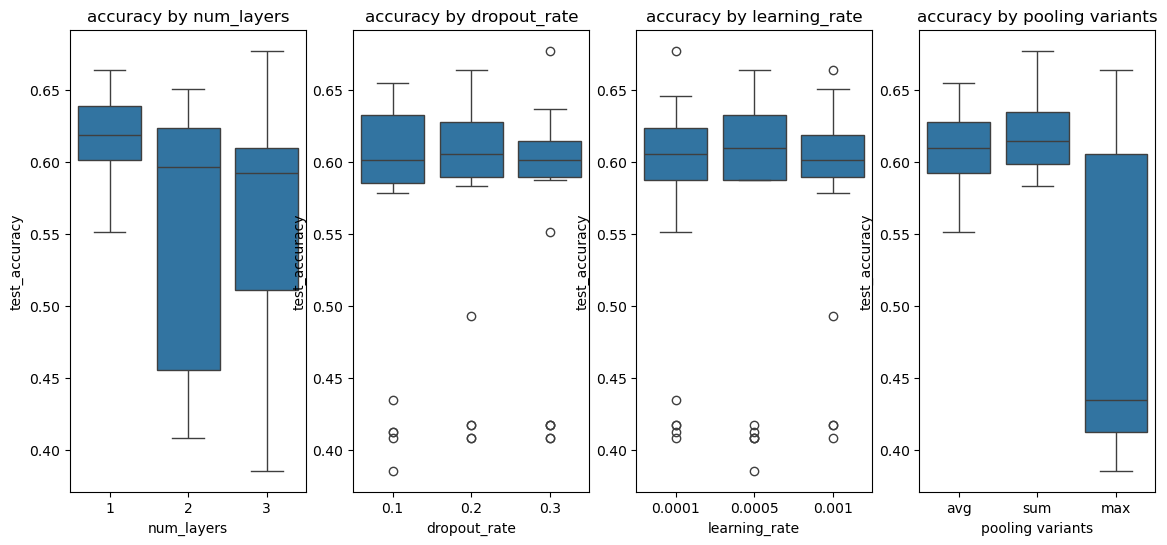

In [23]:
hp_results = pd.DataFrame(results)
plt.figure(figsize=(14,6))

for i, param in enumerate(['num_layers', 
                           'dropout_rate', 
                           'learning_rate',
                           'pooling variants']):
    plt.subplot(1,4,i+1)
    sns.boxplot(x=param, y='test_accuracy', data=hp_results)
    plt.title(f"accuracy by {param}")

plt.show()
    

1 layer, dropout rate of 0.1, learning rate of 0.0005, and avg pooling performed the best. 

In [24]:
# train best model on full training data

best_model = build_gcn_model(1, 0.1, 'avg', 0.0005, 4, 2)

best_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=20
)

best_loss, best_accuracy = best_model.evaluate(
    test_loader.load(),
    steps=test_loader.steps_per_epoch)

print(f"Final test loss: {best_loss:.3f}")
print(f"Final test accuracy: {best_accuracy:.3f}")

Epoch 1/20


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['node_features', 'adjacency_matrix', 'graph_index']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4154 - loss: 7.2092
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4247 - loss: 1.5041
Epoch 3/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.9193

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SubsetDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6023 - loss: 0.8383
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5915 - loss: 0.7706
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6155 - loss: 0.7581
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6091 - loss: 0.7207
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5983 - loss: 0.7326
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5989 - loss: 0.7349
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6078 - loss: 0.6782
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5864 - loss: 0.7186
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6122 - loss: 0.6944
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6364 - loss: 0.6827
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6244 - loss: 0.6994
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 0.685

I think the number of GCN layers had the most significant impact on model performancy. Comparing the effects of different pooling methods, GlobalAvgPool seems to be the most robust. This suggests that averaging node representations could provide a more balanced summary of graph structure than other poolong methods. Regarding performance, the test loss decreased from 0.792 to 0.678 and the final test accuracy increased from 0.623 to 0.650. 